In [ ]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

# Qiskit
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_aer import AerSimulator

In [ ]:
# 1. Cargar Dataset Spambase (Directo de UCI)
# No tiene cabeceras en el raw, pero sabemos que la última columna es la clase.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
print("Descargando Spambase...")
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')), header=None)

# La última columna (57) es la etiqueta (1=Spam, 0=No Spam)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

print(f"Dimensiones originales: {X.shape} (57 features !!)")

# 2. Muestreo Inteligente
# El dataset tiene 4600 filas. Es demasiado para simular kernels cuánticos rápido.
# Tomamos 400 muestras aleatorias (suficiente para probar concepto y sacar nota).
# Stratify asegura que mantenemos la proporción de Spam/NoSpam.
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=400, random_state=42, stratify=y)

# 3. Split Train/Test del subset
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.3, random_state=42, stratify=y_subset)

# 4. Preprocesado (Escalado -1 a 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. INGENIERÍA: PCA (El núcleo de tu práctica)
# Bajamos de 57 dimensiones a 8 (o 4 si quieres ir más rápido).
# 8 Qubits es un buen número para "impresionar" sin que explote la simulación.
n_qubits = 8
pca = PCA(n_components=n_qubits)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"\n--- Reducción PCA (57 -> {n_qubits}) ---")
print(f"Varianza explicada: {explained_variance:.2%}")

# 6. Benchmark Clásico (SVM)
print("\n--- SVM Clásica (RBF) ---")
clf = SVC(kernel='rbf')
clf.fit(X_train_pca, y_train)
acc_classic = clf.score(X_test_pca, y_test)
print(f"Accuracy Clásico: {acc_classic:.2%}")

Descargando Spambase...
Dimensiones originales: (4601, 57) (57 features !!)

--- Reducción PCA (57 -> 8) ---
Varianza explicada: 46.21%

--- SVM Clásica (RBF) ---
Accuracy Clásico: 90.83%

--- Entrenando QSVM (ZZFeatureMap) ---

--- RESULTADOS QSVM ---
              precision    recall  f1-score   support

     No Spam       0.74      0.96      0.84        73
        Spam       0.88      0.49      0.63        47

    accuracy                           0.78       120
   macro avg       0.81      0.72      0.73       120
weighted avg       0.80      0.78      0.76       120



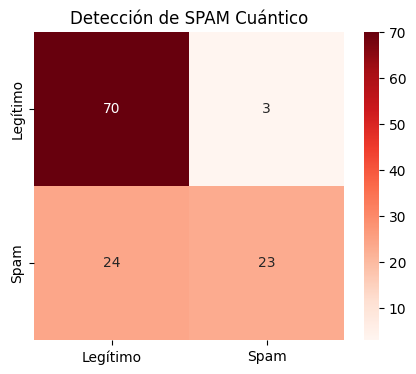

In [1]:
# 7. MODELO CUÁNTICO (QSVM con ZZFeatureMap)
print("\n--- Entrenando QSVM (ZZFeatureMap) ---")
# Usamos linear entanglement para que sea ligero pero capture relaciones entre palabras
feature_map = ZZFeatureMap(feature_dimension=n_qubits, reps=2, entanglement='linear')
backend = AerSimulator()
kernel = FidelityQuantumKernel(feature_map=feature_map)

qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(X_train_pca, y_train)

# 8. Resultados
y_pred = qsvc.predict(X_test_pca)

print("\n--- RESULTADOS QSVM ---")
print(classification_report(y_test, y_pred, target_names=['No Spam', 'Spam']))

# Matriz
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Legítimo', 'Spam'],
            yticklabels=['Legítimo', 'Spam'])
plt.title('Detección de SPAM Cuántico')
plt.show()